# Homogén adatok átalakítása modell tanításhoz

In [1]:
import pandas as pd
import numpy as np
from config import generated_files_path
import random
import calendar
from datetime import datetime


from sklearn.preprocessing import MinMaxScaler

Random napok generálása a tanuló napok és validációs napok kiválasztására

In [2]:


import random
from datetime import datetime, timedelta
random.seed(42)
def random_dates(years,validation_day_no, size_reducing_day_no):
    all_random_dates=validation_day_no+size_reducing_day_no
    dates = []
    size_reducing_dates=[]
    for year in years:  
        for month in range(1, 13):
            for i in range(all_random_dates):
                # Generate a random day in the current month
                day = random.randint(1, 28)  # To avoid issues with different month lengths
                date = datetime(year, month, day).date()
                if i>=validation_day_no:
                    size_reducing_dates.append(date)
                else:
                    dates.append(date)
    return dates,size_reducing_dates

# Example usage
years = [2022,2023]
random_days,days_to_keep = random_dates(years,3,10)
for date in random_days:
    print(date)

2022-01-21
2022-01-04
2022-01-01
2022-02-03
2022-02-19
2022-02-14
2022-03-23
2022-03-21
2022-03-23
2022-04-26
2022-04-06
2022-04-23
2022-05-04
2022-05-12
2022-05-28
2022-06-03
2022-06-18
2022-06-10
2022-07-22
2022-07-08
2022-07-25
2022-08-27
2022-08-12
2022-08-06
2022-09-21
2022-09-06
2022-09-18
2022-10-22
2022-10-11
2022-10-27
2022-11-03
2022-11-07
2022-11-19
2022-12-05
2022-12-08
2022-12-24
2023-01-05
2023-01-17
2023-01-16
2023-02-14
2023-02-20
2023-02-03
2023-03-24
2023-03-04
2023-03-22
2023-04-15
2023-04-01
2023-04-24
2023-05-27
2023-05-21
2023-05-17
2023-06-20
2023-06-11
2023-06-16
2023-07-03
2023-07-03
2023-07-24
2023-08-18
2023-08-06
2023-08-09
2023-09-23
2023-09-10
2023-09-13
2023-10-11
2023-10-01
2023-10-19
2023-11-03
2023-11-02
2023-11-28
2023-12-24
2023-12-19
2023-12-19


In [31]:

raw_data=pd.read_pickle(generated_files_path+'data.pkl')



In [32]:
raw_data.drop(columns=['Loc','SZH_KOD_x','SZH_KOD_y','stop_lat','stop_lon','Time','Legközelebbi met. állomás','IndulóÁllomás','ALLOMAS'],inplace=True)

In [33]:
raw_data.shape

(4027684, 44)

In [34]:
raw_data.head()

,VONATSZAM,KOZLEKEDESI_NAP,ESEMENY,ESEMENY_SORSZAM,IDO,TENY_IDO,OSSZ_KESES (m),TERV_IDOTARTAM (m),KESES (m),TENY_IDOTARTAM (m),...,ÁI,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
0,2010,2022-01-01,2,1,2022-01-01 00:25:00,2022-01-01 00:25:24,0.400000,0.0,0.400000,0.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,2010,2022-01-01,1,2,2022-01-01 00:29:00,2022-01-01 00:30:10,1.166667,4.0,0.766667,4.766667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,2010,2022-01-01,2,3,2022-01-01 00:30:00,2022-01-01 00:30:40,0.666667,1.0,-0.500000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,2010,2022-01-01,1,4,2022-01-01 00:35:00,2022-01-01 00:34:55,-0.083333,5.0,-0.750000,4.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4,2010,2022-01-01,2,5,2022-01-01 00:36:00,2022-01-01 00:36:09,0.150000,1.0,0.233333,1.233333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [35]:
#ezek csak a kezdo megálló nevei a met infóhoz..
raw_data.drop(columns=['SZH_NEV','POLGARI_NEV','stop_name'],inplace=True)

In [36]:
zero_time_rows=raw_data[raw_data['TERV_IDOTARTAM (m)']+raw_data['KESES (m)']==0.0]

In [37]:
zero_time_rows.tail()
# ha ezek opcionális megállók, áthaladások - 0 terv 0 tény ki lesz véve - 
# 0 terv, nem 0 tény - megálltunk - kisebb mint 3 perc mondjuk azt mondjuk hogy nem hiba. 



,VONATSZAM,KOZLEKEDESI_NAP,ESEMENY,ESEMENY_SORSZAM,IDO,TENY_IDO,OSSZ_KESES (m),TERV_IDOTARTAM (m),KESES (m),TENY_IDOTARTAM (m),...,ÁI,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
107814,37455,2023-12-31,4,0,2023-12-31 13:12:00,2023-12-31 13:12:00,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.266667,1.0,False
107834,37463,2023-12-31,4,0,2023-12-31 15:12:00,2023-12-31 15:12:00,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.450000,1.0,False
107869,37463,2023-12-31,3,34,2023-12-31 17:24:00,2023-12-31 17:26:06,2.100000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,False
107871,37463,2023-12-31,3,35,2023-12-31 17:25:00,2023-12-31 17:26:26,1.433333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,False
107874,37467,2023-12-31,4,0,2023-12-31 07:12:00,2023-12-31 07:12:00,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.600000,1.0,False


In [38]:
zero_time_rows.shape

(545980, 41)

In [39]:
raw_data.isnull().values.any() 

False

In [40]:
raw_data.isin([np.inf, -np.inf]).any() 


VONATSZAM                                  False
KOZLEKEDESI_NAP                            False
ESEMENY                                    False
ESEMENY_SORSZAM                            False
IDO                                        False
TENY_IDO                                   False
OSSZ_KESES (m)                             False
TERV_IDOTARTAM (m)                         False
KESES (m)                                  False
TENY_IDOTARTAM (m)                         False
RELATIV_KESES                              False
ELOZO_SZAKASZ_TERV_IDOTARTAM (m)           False
ELOZO_SZAKASZ_KESES (m)                    False
ELOZO_SZAKASZ_RELATIV_KESES                False
ID                                         False
CSATL_MAX_KESES (m)                        False
PUFFER                                     False
MENETREND_IDO (m)                          False
tx                                         False
t                                          False
tn                  

In [41]:
np.isinf(raw_data[['RELATIV_KESES','ELOZO_SZAKASZ_RELATIV_KESES','ELOZO_VONAT_RELATIV_KESES']]).values.sum()

0

# Validáció adat full verziója

In [42]:
#raw_data['KOZLEKEDESI_NAP']=pd.to_datetime(raw_data['ELOZO_ESEMENY_IDO']).dt.date
df_to_validate_orig = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(random_days)]




C:\Users\ELTE\AppData\Local\Temp\ipykernel_19620\2797493571.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_to_validate_orig = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(random_days)]


In [43]:
df_to_validate_orig.to_pickle(generated_files_path+'validation_orig.pkl')
del df_to_validate_orig

In [44]:
# nem kellene már...
import datetime
def convert_time_to_minute(input):
    if isinstance(input,datetime.time):
        return float(input.hour*60+input.minute)
    #TODO does totalseconds return some decent value for negativ timedelta? 
    # ANS: it is good
    if isinstance(input,datetime.timedelta):
        ret = input.total_seconds()/60
       # if datetime.timedelta(0)>input:
       #     return -ret
        return ret
    if isinstance(input,float):
        return input
    return -1.0

In [45]:
# átalakítjuk időt percekké

In [46]:
raw_data.head()

,VONATSZAM,KOZLEKEDESI_NAP,ESEMENY,ESEMENY_SORSZAM,IDO,TENY_IDO,OSSZ_KESES (m),TERV_IDOTARTAM (m),KESES (m),TENY_IDOTARTAM (m),...,ÁI,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
0,2010,2022-01-01,2,1,2022-01-01 00:25:00,2022-01-01 00:25:24,0.400000,0.0,0.400000,0.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,2010,2022-01-01,1,2,2022-01-01 00:29:00,2022-01-01 00:30:10,1.166667,4.0,0.766667,4.766667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,2010,2022-01-01,2,3,2022-01-01 00:30:00,2022-01-01 00:30:40,0.666667,1.0,-0.500000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,2010,2022-01-01,1,4,2022-01-01 00:35:00,2022-01-01 00:34:55,-0.083333,5.0,-0.750000,4.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4,2010,2022-01-01,2,5,2022-01-01 00:36:00,2022-01-01 00:36:09,0.150000,1.0,0.233333,1.233333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [47]:
#atzt tartjuk meg, ami kell a traininghez és predikcióhoz
def prepare_for_ml_models(raw_data):
    to_drop=['VONATSZAM','IDO',"TENY_IDO","RELATIV_KESES","ID","OSSZ_KESES (m)",'TENY_IDOTARTAM (m)',"Kezdés","Befejezés"]
    #raw_data[['MENETREND_IDO','ELOZO_KESES','ELOZO VONAT KESES','KESES']] = raw_data[['MENETREND_IDO','ELOZO_KESES','ELOZO VONAT KESES','KESES']].map(convert_time_to_minute)
    raw_data.drop(to_drop,axis=1,inplace=True)   
    raw_data['VONAL_STATUSZ_VALTOZOTT']=raw_data['VONAL_STATUSZ_VALTOZOTT'].astype(float)
    raw_data.fillna(0.0,inplace=True)
    
prepare_for_ml_models(raw_data)

In [48]:
#TODO boolean vs categorical?
#TODO Vonal, Line mit kellene kezdeni velük? kicsit kölséges használni őket..
#raw_data[['VONATSZAM','VONAL','VONTATO_TIPUS','Lassúmenet típusa','Kizárás (1=VZ,2=LJ)','Kiutalt menetvonalak zavartatása nélkül','Státus','Fels.vez. kikapcsolása']]=raw_data[['VONATSZAM','VONAL','VONTATO_TIPUS','Lassúmenet típusa','Kizárás (1=VZ,2=LJ)','Kiutalt menetvonalak zavartatása nélkül','Státus','Fels.vez. kikapcsolása']].astype("category")

# sklearn nem bír  category-kal
#raw_data.drop(columns=['VONATSZAM','VONAL','VONTATO_TIPUS'],inplace=True)

# vonatszám kell majd spearman-hez
#raw_data.drop(columns=['VONAL','VONTATO_TIPUS'],inplace=True)


In [49]:

raw_data.dtypes


KOZLEKEDESI_NAP                            datetime64[ns]
ESEMENY                                             int64
ESEMENY_SORSZAM                                     int64
TERV_IDOTARTAM (m)                                float64
KESES (m)                                         float64
ELOZO_SZAKASZ_TERV_IDOTARTAM (m)                  float64
ELOZO_SZAKASZ_KESES (m)                           float64
ELOZO_SZAKASZ_RELATIV_KESES                       float64
CSATL_MAX_KESES (m)                               float64
PUFFER                                            float64
MENETREND_IDO (m)                                   int64
tx                                                float64
t                                                 float64
tn                                                float64
r                                                 float64
LINE                                                int64
Érintett objektum típusa                          float64
Lassúmenet típ

In [51]:
raw_data.tail()

,KOZLEKEDESI_NAP,ESEMENY,ESEMENY_SORSZAM,TERV_IDOTARTAM (m),KESES (m),ELOZO_SZAKASZ_TERV_IDOTARTAM (m),ELOZO_SZAKASZ_KESES (m),ELOZO_SZAKASZ_RELATIV_KESES,CSATL_MAX_KESES (m),PUFFER,...,I,E,ÁI,ÁE,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
107889,2023-12-31,2,15,0.0,0.200000,5.0,0.250000,0.024390,0.0,-0.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300000,1.000000,0.0
107890,2023-12-31,1,16,5.0,-0.466667,0.0,0.200000,1.000000,0.0,4.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.766667,-0.083032,0.0
107891,2023-12-31,2,17,0.0,0.300000,5.0,-0.466667,-0.048951,0.0,0.466667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.383333,1.000000,0.0
107892,2023-12-31,1,18,11.0,0.166667,0.0,0.300000,1.000000,0.0,10.700000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.816667,0.035793,0.0
107893,2023-12-31,5,19,0.0,-0.733333,11.0,0.166667,0.007519,0.0,-0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.383333,0.089924,0.0


In [52]:
df_to_validate = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(random_days)]
#NEM HASZNÁLJUK AZ EGÉSZ ADATOT
df_remaining = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(days_to_keep)]
del raw_data

C:\Users\ELTE\AppData\Local\Temp\ipykernel_19620\3482023882.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_to_validate = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(random_days)]
C:\Users\ELTE\AppData\Local\Temp\ipykernel_19620\3482023882.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_remaining = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(days_to_keep)]


In [53]:
#ez is kell spearmann-hez
df_to_validate.drop(columns=['KOZLEKEDESI_NAP'],inplace=True)
df_remaining.drop(columns=['KOZLEKEDESI_NAP'],inplace=True)


In [54]:
#df_to_validate.drop(columns=['ID'],inplace=True)
#df_remaining.drop(columns=['ID'],inplace=True)
#raw_data.to_csv(data_root+'preprocessed_data.csv', index=False)
df_to_validate.to_csv(generated_files_path+'validation_data.csv', index=False)
df_remaining.to_csv(generated_files_path+'train_test_data.csv', index=False)



In [55]:
del df_to_validate
del df_remaining

# Modellek tanítása

A modellek tanításához elég innentől futtatni.

In [12]:
import pandas as pd
from config import generated_files_path

raw_data=pd.read_csv(generated_files_path+'train_test_data.csv')
#raw_data['VONAL STATUSZ VALTOZOTT']=raw_data['VONAL STATUSZ VALTOZOTT'].head().astype(float)



In [13]:

raw_data.columns


Index(['ESEMENY', 'ESEMENY_SORSZAM', 'TERV_IDOTARTAM (m)', 'KESES (m)',
       'ELOZO_SZAKASZ_TERV_IDOTARTAM (m)', 'ELOZO_SZAKASZ_KESES (m)',
       'ELOZO_SZAKASZ_RELATIV_KESES', 'CSATL_MAX_KESES (m)', 'PUFFER',
       'MENETREND_IDO (m)', 'tx', 't', 'tn', 'r', 'LINE',
       'Érintett objektum típusa', 'Lassúmenet típusa', 'Lassúmenet hossza',
       'Lassúmenet mértéke (km/h)', 'Lassúmenet mértéke motorvonatra (km/h)',
       'Fels.vez. kikapcsolása', 'I', 'E', 'ÁI', 'ÁE', 'Kizárás (1=VZ,2=LJ)',
       'Kiutalt menetvonalak zavartatása nélkül', 'Státus',
       'ELOZO_VONAT_KESES (m)', 'ELOZO_VONAT_RELATIV_KESES',
       'VONAL_STATUSZ_VALTOZOTT'],
      dtype='object')

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
def split_train_test(data, normalize=False):
    raw_data=data.copy()
    X_scaler=None
    y_scaler=None
    pd_y= raw_data[['KESES (m)']]
    pd_X = raw_data.drop(columns=['KESES (m)'])
    if 'RELATIV_KESES' in raw_data.columns:
        pd_X.drop(columns=['RELATIV_KESES'],inplace=True)
    if normalize:
        X_scaler = MinMaxScaler()
        pd_X[pd_X.columns] = X_scaler.fit_transform(pd_X[pd_X.columns])
        y_scaler=MinMaxScaler()
        pd_y[pd_y.columns] = y_scaler.fit_transform(pd_y[pd_y.columns])
   
    '''
    if normalize:
        scaler = MinMaxScaler()
        pd_X[pd_X.columns] = scaler.fit_transform(pd_X[pd_X.columns])
    '''
    X_train, X_test, y_train, y_test = train_test_split(pd_X, pd_y, test_size=0.3, random_state=44)
    return X_train, X_test, y_train, y_test,X_scaler,y_scaler

In [15]:
X_train, X_test, y_train, y_test,_,_ = split_train_test(raw_data)
#X_train.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)
#X_test.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)

''''
TrTD= X_train[['VONATSZAM','KOZLEKEDESI_NAP']]
X_train.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)
TeTD= X_test[['VONATSZAM','KOZLEKEDESI_NAP']]
X_test.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)
'''

"'\nTrTD= X_train[['VONATSZAM','KOZLEKEDESI_NAP']]\nX_train.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)\nTeTD= X_test[['VONATSZAM','KOZLEKEDESI_NAP']]\nX_test.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)\n"

In [16]:
X_train.head()

,ESEMENY,ESEMENY_SORSZAM,TERV_IDOTARTAM (m),ELOZO_SZAKASZ_TERV_IDOTARTAM (m),ELOZO_SZAKASZ_KESES (m),ELOZO_SZAKASZ_RELATIV_KESES,CSATL_MAX_KESES (m),PUFFER,MENETREND_IDO (m),tx,...,I,E,ÁI,ÁE,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
478472,3,30,0.0,1.0,0.616667,0.235669,16.316667,-0.616667,959,24.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
334870,1,15,2.0,1.0,-0.416667,-0.263158,0.000000,2.416667,872,7.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300000,0.069767,0.0
803000,2,19,1.0,2.0,0.200000,0.047619,0.000000,0.800000,1366,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.783333,0.654179,0.0
942254,2,16,0.0,2.0,0.366667,0.083969,0.000000,-0.366667,1202,31.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.766667,1.000000,0.0
624557,1,7,3.0,1.0,-0.283333,-0.165049,0.000000,3.283333,455,11.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316667,0.050132,0.0


# DecisionTreeRegressor

In [17]:
import numpy as np

In [51]:
max_depth=[]

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# https://www.geeksforgeeks.org/how-to-tune-a-decision-tree-in-hyperparameter-tuning/
def train_DRT(X_train, X_test, y_train):
    
    # Define the parameter grid to tune the hyperparameters
    param_grid = {
        'max_depth': [10, 20, 30, None],
    }
    dtree_reg = DecisionTreeRegressor(random_state=42) # Initialize a decision tree regressor
    grid_search = GridSearchCV(estimator=dtree_reg, param_grid=param_grid, 
                           cv=3, n_jobs=-1,verbose=2,scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(best_params)
    predictions = model.predict(X_test)
    return model, predictions
'''
def train_DRTF(X_train, X_test, y_train):
    
        # Define the parameter grid to tune the hyperparameters
    param_grid = {
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    dtree_reg = RandomForestRegressor(random_state=42) # Initialize a decision tree regressor
    grid_search = GridSearchCV(estimator= dtree_reg, param_grid=param_grid, 
                           cv=3, n_jobs=-1,verbose=2,scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    predictions = model.predict(X_test)
    return model, predictions
'''
model, predictions = train_DRT(X_train,X_test, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits



KeyboardInterrupt



 $$\text{SMAPE} = \frac{100}{n} \sum_{t=1}^n \frac{\left|F_t-A_t\right|}{(|A_t|+|F_t|)/2}$$

In [18]:

def evaluate_model(X_test, y_test, predictions):
    eval_df=pd.concat([X_test[['TERV_IDOTARTAM (m)']],y_test],axis=1)
    eval_df['predictions']=predictions
    eval_df['AE']=abs(eval_df['KESES (m)']+eval_df['predictions'])
    eval_df['Tény']=eval_df['TERV_IDOTARTAM (m)']+eval_df['KESES (m)']
    eval_df['Pred']=eval_df['TERV_IDOTARTAM (m)']+eval_df['predictions']
    eval_df=eval_df[eval_df['TERV_IDOTARTAM (m)']>0]
    eval_df['MAPE (KESES)']=abs((eval_df['Tény']-eval_df['Pred'])/eval_df['Tény']) *100
    eval_df['MAPE (MENETIDO)']=abs((eval_df['KESES (m)']-eval_df['predictions'])/eval_df['KESES (m)']) *100
    eval_df['SMAPE (KESES)']=abs(eval_df['predictions']-eval_df['KESES (m)'])/((abs(eval_df['KESES (m)'])+abs(eval_df['predictions']))/2) *100
    eval_df['SMAPE (MENETIDO)']=abs(eval_df['Pred']-eval_df['Tény'])/((abs(eval_df['Tény'])+abs(eval_df['Pred']))/2) *100


    return eval_df 

In [65]:
eval_df = evaluate_model(X_test, y_test, predictions)


In [66]:
eval_df[['KESES (m)','AE',"MAPE (KESES)","MAPE (MENETIDO)","SMAPE (KESES)","SMAPE (MENETIDO)"]].describe()

,KESES (m),AE,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
count,235047.000000,235047.000000,2.350470e+05,2.350350e+05,235035.000000,235047.000000
mean,-0.118223,0.840609,inf,inf,93.693649,17.478052
std,0.817938,0.983541,NaN,NaN,75.447375,23.250691
min,-18.216667,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,-0.450000,0.249469,3.289153e+00,2.211237e+01,23.374732,3.304649
50%,-0.133333,0.577311,8.506368e+00,5.962302e+01,70.688955,8.594414
75%,0.200000,1.026038,2.251904e+01,1.121019e+02,191.926712,22.401126
max,30.666667,29.896990,inf,inf,200.000000,200.000000


In [67]:
eval_df1=eval_df[eval_df['Tény']!=0.0]



In [68]:
eval_df1[['KESES (m)','AE',"MAPE (KESES)","MAPE (MENETIDO)","SMAPE (KESES)","SMAPE (MENETIDO)"]].describe()

,KESES (m),AE,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
count,235008.000000,235008.000000,235008.000000,2.349960e+05,234996.000000,235008.000000
mean,-0.117868,0.840245,22.771281,inf,93.688478,17.447762
std,0.817393,0.982903,161.321733,NaN,75.446903,23.133414
min,-18.216667,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,-0.450000,0.249469,3.289153,2.211237e+01,23.374732,3.304649
50%,-0.133333,0.577311,8.505387,5.962302e+01,70.678380,8.594414
75%,0.200000,1.024582,22.513023,1.121019e+02,191.926712,22.399664
max,30.666667,29.896990,37538.092308,inf,200.000000,200.000000


In [188]:
eval_df_XXX=evaluate_model(X_test, y_test, np.zeros(y_test.shape))


In [190]:
eval_df_XXX[['KESES (m)','AE',"SMAPE (KESES)","SMAPE (MENETIDO)"]].describe()

,KESES (m),AE,SMAPE (KESES),SMAPE (MENETIDO)
count,235047.000000,2.350470e+05,235047.0,235047.000000
mean,-0.118223,5.164310e-01,200.0,27.491412
std,0.817938,6.452111e-01,0.0,26.704126
min,-18.216666,8.488695e-07,200.0,0.000004
25%,-0.450001,1.500008e-01,200.0,7.073956
50%,-0.133334,3.666667e-01,200.0,20.183534
75%,0.199999,6.166655e-01,200.0,40.000113
max,30.666664,3.066666e+01,200.0,200.000000


In [71]:
eval_df.head()

,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
420350,2.0,-0.066667,-0.094974,0.161641,1.933333,1.905026,1.464190,42.461517,35.025366,1.474989
56121,1.0,0.300000,0.143978,0.443978,1.300000,1.143978,12.001700,52.007367,70.283724,12.767881
1006891,3.0,-0.450000,-0.358958,0.808958,2.550000,2.641042,3.570292,20.231655,22.508584,3.507675
702620,1.0,-0.733333,-0.615424,1.348758,0.266667,0.384576,44.215900,16.078509,17.484100,36.210501
257760,2.0,0.133333,0.016136,0.149469,2.133333,2.016136,5.493631,87.898103,156.818225,5.648793


In [72]:
sorted_mape_keses = eval_df1.sort_values('SMAPE (KESES)', ascending=False)

In [73]:
sorted_mape_keses.head(10)

,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
981015,2.0,-0.100000,0.016136,0.083864,1.900000,2.016136,6.112414,116.135863,200.0,5.931146
418924,2.0,0.033333,-0.124472,0.091139,2.033333,1.875528,7.760921,473.416177,200.0,8.074239
68353,3.0,1.083333,-0.705343,0.377990,4.083333,2.294657,43.804328,165.108620,200.0,56.089042
1087378,1.0,-0.183333,0.016136,0.167197,0.816667,1.016136,24.424800,108.801380,200.0,21.766578
522170,1.0,0.383333,-0.094974,0.288359,1.383333,0.905026,34.576459,124.775916,200.0,41.803553
496804,1.0,-0.516667,0.016136,0.500531,0.483333,1.016136,110.235006,103.123070,200.0,71.065485
62239,6.0,0.016667,-0.132221,0.115554,6.016667,5.867779,2.474582,893.324061,200.0,2.505583
305214,2.0,0.000000,0.016136,0.016136,2.000000,2.016136,0.806793,inf,200.0,0.803552
966370,1.0,-0.333333,0.781587,0.448253,0.666667,1.781587,167.238005,334.476010,200.0,91.078811
456571,3.0,-0.150000,0.016136,0.133864,2.850000,3.016136,5.829329,110.757242,200.0,5.664235


In [74]:
sorted_mape_keses.tail(10)


,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
397541,1.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0
396552,1.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0
717877,1.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0
831108,1.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0
1137640,1.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0
1142198,1.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0
790925,5.0,0.0,0.0,0.0,5.0,5.0,0.0,NaN,NaN,0.0
1140074,1.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0
350866,1.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0
748231,2.0,0.0,0.0,0.0,2.0,2.0,0.0,NaN,NaN,0.0


In [75]:
sorted_mape_menetido = eval_df.sort_values('MAPE (MENETIDO)', ascending=False)


In [76]:
sorted_mape_menetido.head()

,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
956411,2.0,0.0,0.726595,0.726595,2.0,2.726595,36.329755,inf,200.0,30.744969
930703,1.0,0.0,0.143978,0.143978,1.0,1.143978,14.397790,inf,200.0,13.430913
260388,2.0,0.0,0.016136,0.016136,2.0,2.016136,0.806793,inf,200.0,0.803552
178993,2.0,0.0,-0.094974,0.094974,2.0,1.905026,4.748717,inf,200.0,4.864211
1118611,3.0,0.0,0.016136,0.016136,3.0,3.016136,0.537862,inf,200.0,0.536420


In [77]:
sorted_mape_menetido.tail()


,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
1142198,1.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0
790925,5.0,0.0,0.0,0.0,5.0,5.0,0.0,NaN,NaN,0.0
1140074,1.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0
350866,1.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0
748231,2.0,0.0,0.0,0.0,2.0,2.0,0.0,NaN,NaN,0.0


In [19]:
import joblib
# modellek mentése, beolvasása:
# könyvtárszerkezet: <model gyökér>/<model típus>/<használt adat típusa>/<plusz infó>/<model file(ok)> 

import matplotlib.pyplot as plt

from config import model_location
import os
# Check if the directory exists
if not os.path.exists(model_location):
    # Create the directory
    os.makedirs(model_location)

def get_location_and_name(model_name, model_desc,data_desc):
    loc=   model_location+'/'+model_name+'/'+data_desc+'/'+model_desc+"/"
    name = model_name + '_' + data_desc + '_' + model_desc
    return loc, name
def save_sklearn_model(model,model_name,data_desc,model_desc='base'):
    loc,name=get_location_and_name(model_name,model_desc,data_desc)    
    if not os.path.exists(loc):
        # Create the directory
        os.makedirs(loc)
    # Save the model to a file
    joblib.dump(model, f'{loc}{name}.joblib')
    
def get_nn_model_name(epochs, data_desc):
    return f'NN_{data_desc}_epoch_{epochs}'

def save_NN(model,X_scaler,y_scaler,history,data_desc, model_desc='base'):
    loc,name=get_location_and_name('NN',model_desc,data_desc)    
    if not os.path.exists(loc):
        # Create the directory
        os.makedirs(loc) 
    save_sklearn_model(X_scaler,'X_scaler',data_desc)
    save_sklearn_model(y_scaler,'y_scaler',data_desc)
    torch.save(model, loc+name+'.pth')


    for k, v in history.items():
        plt.plot(v, label='lr=' + str(k))

    plt.legend(loc="upper left")

    plt.savefig(loc+'history.png')

def load_NN(path):
    ret={}
    for f in os.listdir(path):
        if f.endswith('.pth'):
            print('Loading model:', path+f)
            ret['model'] = torch.load(path+f, weights_only=False)
        elif f.endswith('.joblib'):
            if 'X_scaler' in f:
                ret['X_scaler'] = joblib.load(path+f)
            elif 'y_scaler' in f:
                ret['y_scaler'] = joblib.load(path+f)
            else:
                print(f'Unspecified joblib file: {f}')
        else:
                print(f'Unspecified file: {f}')
    return ret

def load_NNs(model_path):
    # könyvtárszerkezet: <model gyökér>/<model típus>/<használt adat típusa>/<plusz infó>/<model file(ok)> 

    ret={}
    #dir=data_desc
    for dir in os.listdir(model_path+'NN'):
        ret[dir]={}
        if os.path.isdir(model_path+'NN/'+dir+'/'):
            print('reading '+ dir)
            #dir2=model_desc
            for dir2 in os.listdir(dir):
                print('reading '+ dir+'/'+dir2)
                ret[dir][dir2]['model']=load_NN(model_path+'NN/'+dir+'/'+dir2)
                ret[dir][dir2]['data_desc']=dir
                ret[dir][dir2]['model_desc']=dir2
    return ret

def load_NN_by_desc(model_desc,data_desc):
    loc,name= get_location_and_name('NN',model_desc,data_desc)
    ret=load_NN(loc)
    ret['model_desc']=model_desc
    ret['data_desc']=data_desc
    return ret

def load_sk_by_desc(model_name,model_desc,data_desc):
    loc,name= get_location_and_name(model_name,model_desc,data_desc)
    return {'model':joblib.load(f'{loc}/{name}.joblib'),'model_name':model_name,'data_desc':data_desc,'model_desc':model_desc}
    
    
#def load_models():
    
    



In [79]:
save_sklearn_model(model,'RT','Base')


In [80]:
del model

# Egyszerű neurális háló

In [20]:
X_train.dtypes


ESEMENY                                      int64
ESEMENY_SORSZAM                              int64
TERV_IDOTARTAM (m)                         float64
ELOZO_SZAKASZ_TERV_IDOTARTAM (m)           float64
ELOZO_SZAKASZ_KESES (m)                    float64
ELOZO_SZAKASZ_RELATIV_KESES                float64
CSATL_MAX_KESES (m)                        float64
PUFFER                                     float64
MENETREND_IDO (m)                            int64
tx                                         float64
t                                          float64
tn                                         float64
r                                          float64
LINE                                         int64
Érintett objektum típusa                   float64
Lassúmenet típusa                          float64
Lassúmenet hossza                          float64
Lassúmenet mértéke (km/h)                  float64
Lassúmenet mértéke motorvonatra (km/h)     float64
Fels.vez. kikapcsolása         

plusz normalizálás kellhet:
normalized_df=(df-df.mean())/df.std()
to use min-max normalization:

normalized_df=(df-df.min())/(df.max()-df.min())

kicsit alaposabb tréneléshez: 

https://machinelearningmastery.com/how-to-grid-search-hyperparameters-for-pytorch-models/

In [4]:
print('hello')

hello


In [21]:
#X=pd_X.values
#y=pd_y.values
import torch
# train-test split of the dataset

X_train, X_test, y_train, y_test,X_scaler,y_scaler = split_train_test(raw_data,True)
def get_data_tensors(X_train, X_test, y_train, y_test):
    X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_t = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)
    return X_train_t, X_test_t, y_train_t, y_test_t
X_train_t, X_test_t, y_train_t, y_test_t = get_data_tensors(X_train, X_test, y_train, y_test)


C:\Users\ELTE\AppData\Local\Temp\ipykernel_8804\4010718233.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_y[pd_y.columns] = y_scaler.fit_transform(pd_y[pd_y.columns])


In [22]:
input_size=X_train.shape[1]

In [23]:
import torch
import torch.nn as nn
# Define the model
        


def get_NN_model(input_size):
    model = nn.Sequential(
        nn.Linear(input_size, 24),
        nn.ReLU(),
        nn.Linear(24, 12),
        nn.ReLU(),
        nn.Linear(12, 6),
        nn.ReLU(),
        nn.Linear(6, 1)
    )
    return model

In [24]:
model_nn = get_NN_model(input_size)

In [25]:
import torch.nn as nn
import torch.optim as optim

class SMAPELoss(nn.Module):
    def __init__(self):
        super(SMAPELoss, self).__init__()

    def forward(self, y_pred, y_true):
        epsilon = 1e-8  # to avoid division by zero
        numerator = torch.abs(y_pred - y_true)
        denominator = (torch.abs(y_pred) + torch.abs(y_true) + epsilon) / 2.0
        smape = numerator / denominator
        return torch.mean(smape)

# loss function and optimizer
def get_optimizer(model,loss="mse", lr=0.0001):
    
    if loss=="smape":
        print("Loss SMAPE")
        loss_fn=SMAPELoss()   
    else:
        print("Loss MSE")
        loss_fn=nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr)
    return optimizer, loss_fn

In [26]:
optimizer, loss_fn = get_optimizer(model_nn, 0.0001)

Loss MSE


In [89]:
X_train.shape

(811901, 30)

In [27]:
import numpy as np
import torch
import tqdm.notebook
import copy
from sklearn.model_selection import train_test_split

'''
# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
'''
def reset_model(model):
    for layer in model.children():
       if hasattr(layer, 'reset_parameters'):
           print(f'resetting {layer.__class__.__name__}')
           layer.reset_parameters()

def train_NN(X_train, X_test, y_train, y_test, model, loss_fn, optimizer,n_epochs = 10):
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = {}
    for loss_name in ['mse']:
        #for lr in [0.0001, 0.001, 0.0005]:
        for lr in [ 0.0005]:
            print("======================================")
            print(f'lr={lr}m, loss:{loss_name}')
            reset_model(model)
            optimizer, loss_fn=get_optimizer(model, loss_name, lr)
            history[lr] = []
            # training loop
            for epoch in range(n_epochs):
                model.train()
                with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                    bar.set_description(f"Epoch {epoch}")
                    for start in bar:
                        # take a batch
                        X_batch = X_train[start:start+batch_size]
                        y_batch = y_train[start:start+batch_size]
                        optimizer.zero_grad()
                        # forward pass
                        y_pred = model(X_batch)
                        loss = loss_fn(y_pred, y_batch)
                       
                        # backward pass
                        loss.backward()
                        # update weights
                        optimizer.step()
                        # print progress
                        bar.set_postfix(mse=float(loss))
                # evaluate accuracy at end of each epoch
                model.eval()
                y_pred = model(X_test)
                mse = loss_fn(y_pred, y_test)
                mse = float(mse)
                print("Epoch:",epoch,loss_name,": ", mse, f'Best {loss_name}',best_mse)
                history[lr].append(mse)
                if mse < best_mse:
                    best_mse = mse
                    best_weights = copy.deepcopy(model.state_dict())
         
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return history, best_mse, best_weights, model

In [28]:
history, best_mse, best_weights, model_nn=train_NN(X_train_t, X_test_t, y_train_t, y_test_t, model_nn, None, None,30)

lr=0.0005m, loss:mse
resetting Linear
resetting Linear
resetting Linear
resetting Linear
Loss MSE
Epoch: 0 mse :  4.546630952972919e-05 Best mse inf
Epoch: 1 mse :  4.903835360892117e-05 Best mse 4.546630952972919e-05
Epoch: 2 mse :  4.793873813468963e-05 Best mse 4.546630952972919e-05
Epoch: 3 mse :  4.4163585698697716e-05 Best mse 4.546630952972919e-05
Epoch: 4 mse :  4.073943637195043e-05 Best mse 4.4163585698697716e-05
Epoch: 5 mse :  3.8678699638694525e-05 Best mse 4.073943637195043e-05
Epoch: 6 mse :  3.8077716453699395e-05 Best mse 3.8678699638694525e-05
Epoch: 7 mse :  3.671870945254341e-05 Best mse 3.8077716453699395e-05
Epoch: 8 mse :  3.631630170275457e-05 Best mse 3.671870945254341e-05
Epoch: 9 mse :  3.592524444684386e-05 Best mse 3.631630170275457e-05
Epoch: 10 mse :  3.560430559446104e-05 Best mse 3.592524444684386e-05
Epoch: 11 mse :  3.5858680348610505e-05 Best mse 3.560430559446104e-05
Epoch: 12 mse :  3.5917746572522447e-05 Best mse 3.560430559446104e-05
Epoch: 13 ms

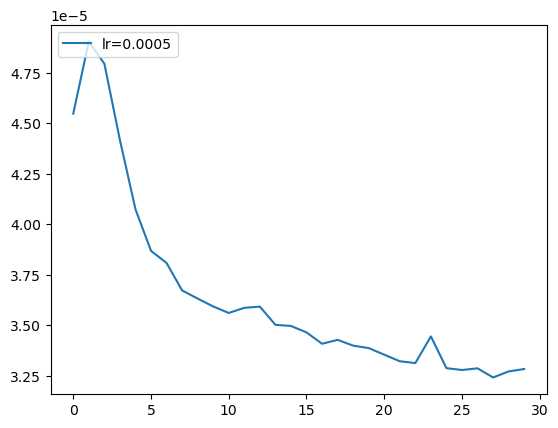

In [29]:
import matplotlib.pyplot as plt

for k, v in history.items():
    plt.plot(v, label = 'lr='+str(k))
    
plt.legend(loc="upper left")




In [30]:
y_pred = model_nn(X_test_t)

In [31]:
y_pred=y_pred.detach().numpy()

In [32]:
#TODO kell ez? 

X_test[X_test.columns]=X_scaler.inverse_transform(X_test_t)
y_test[y_test.columns] =y_scaler.inverse_transform(y_test_t)

In [33]:
y_pred=y_scaler.inverse_transform(y_pred)


In [34]:
eval_df_nn=evaluate_model(X_test, y_test, y_pred)

In [35]:
eval_df_nn.head()

,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
420350,2.0,-0.066665,-0.106182,0.172847,1.933335,1.893818,2.043974,59.276703,45.724666,2.065078
56121,1.0,0.300001,0.243339,0.543340,1.300001,1.243339,4.358618,18.887307,20.856967,4.455722
1006891,3.0,-0.450001,-0.607679,1.057679,2.549999,2.392322,6.183448,35.039474,29.815820,6.380722
702620,1.0,-0.733334,-0.381456,1.114790,0.266666,0.618544,131.954658,47.983309,63.129002,79.501615
257760,2.0,0.133333,-0.008223,0.125109,2.133333,1.991777,6.635445,106.167609,200.000000,6.863145


In [36]:
eval_df_nn[['KESES (m)','AE',"MAPE (KESES)","MAPE (MENETIDO)","SMAPE (KESES)","SMAPE (MENETIDO)"]].describe()

,KESES (m),AE,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
count,235047.000000,235047.000000,2.350470e+05,2.350470e+05,235047.000000,2.350470e+05
mean,-0.118223,0.831143,3.898662e+04,8.624584e+05,95.543293,1.873516e+01
std,0.817938,0.956625,4.698496e+06,1.151266e+07,72.147158,2.366814e+01
min,-18.216666,0.000018,5.043475e-07,6.556523e-06,0.000007,5.043475e-07
25%,-0.450001,0.249213,4.162094e+00,2.768716e+01,29.695077,4.171331e+00
50%,-0.133334,0.562512,9.977735e+00,6.221490e+01,78.058666,1.006513e+01
75%,0.199999,1.015624,2.416989e+01,1.162259e+02,175.443604,2.409520e+01
max,30.666664,29.386697,1.005856e+09,2.615731e+09,200.000000,2.000000e+02


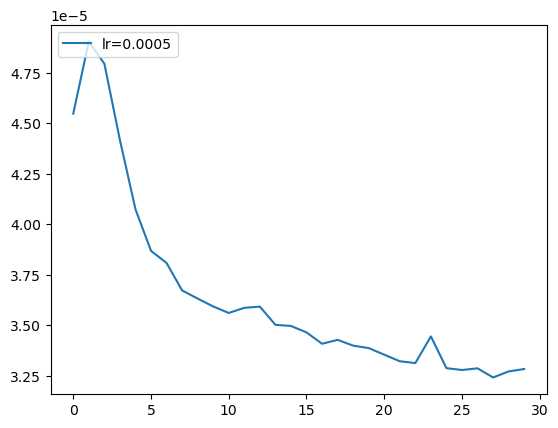

In [37]:
save_NN(model_nn,X_scaler,y_scaler,history,'Base')

In [126]:
del model_nn

# Kisebb adaton:

most rendelkezésre álló adat:
- utastájékoztatásból terv- és tényídők
- időjárás

Azaz dobjuk a lassújel és vágányzár adatokat


In [127]:
raw_data.columns

Index(['ESEMENY', 'ESEMENY_SORSZAM', 'TERV_IDOTARTAM (m)', 'KESES (m)',
       'ELOZO_SZAKASZ_TERV_IDOTARTAM (m)', 'ELOZO_SZAKASZ_KESES (m)',
       'ELOZO_SZAKASZ_RELATIV_KESES', 'CSATL_MAX_KESES (m)', 'PUFFER',
       'MENETREND_IDO (m)', 'tx', 't', 'tn', 'r', 'LINE',
       'Érintett objektum típusa', 'Lassúmenet típusa', 'Lassúmenet hossza',
       'Lassúmenet mértéke (km/h)', 'Lassúmenet mértéke motorvonatra (km/h)',
       'Fels.vez. kikapcsolása', 'I', 'E', 'ÁI', 'ÁE', 'Kizárás (1=VZ,2=LJ)',
       'Kiutalt menetvonalak zavartatása nélkül', 'Státus',
       'ELOZO_VONAT_KESES (m)', 'ELOZO_VONAT_RELATIV_KESES',
       'VONAL_STATUSZ_VALTOZOTT'],
      dtype='object')

In [38]:
attrs_to_use=['MENETREND_IDO','ELOZO_KESES','KESES','tx','t','tn','r','TERV_IDOTARTAM (m)','ELOZO VONAT KESES','ELOZO VONAT RELATIV KESES']
attrs_to_use=['MENETREND_IDO (m)','ELOZO_SZAKASZ_KESES (m)','KESES (m)','tx','t','tn','r','TERV_IDOTARTAM (m)']


In [39]:
raw_data_small=raw_data[attrs_to_use]


In [52]:
def train_and_evaluate_DRT(data):
    history=None
    X_scaler=None
    y_scaler=None
    X_train, X_test, y_train, y_test,_,_ = split_train_test(data)
    model, predictions = train_DRT(X_train,X_test, y_train)
    eval_df = evaluate_model(X_test, y_test, predictions)
    return model,eval_df,X_scaler,y_scaler,history





In [53]:
raw_data_small.head()

,MENETREND_IDO (m),ELOZO_SZAKASZ_KESES (m),KESES (m),tx,t,tn,r,TERV_IDOTARTAM (m)
0,25,0.000000,0.516667,11.7,9.2,6.0,0.0,0.0
1,29,0.516667,0.650000,11.7,9.2,6.0,0.0,4.0
2,30,0.650000,-0.500000,11.7,9.2,6.0,0.0,1.0
3,35,-0.500000,-0.733333,11.7,9.2,6.0,0.0,5.0
4,36,-0.733333,0.250000,11.7,9.2,6.0,0.0,1.0


In [54]:
model_s,eval_df_s,_,_,_=train_and_evaluate_DRT(raw_data_small)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'max_depth': 10}


In [55]:
eval_df_s[['AE',"MAPE (KESES)","MAPE (MENETIDO)","SMAPE (KESES)","SMAPE (MENETIDO)"]].describe()

,AE,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
count,235047.000000,2.350470e+05,2.350340e+05,235034.000000,235047.000000
mean,0.677924,inf,inf,131.448124,24.831153
std,0.819063,NaN,NaN,67.234685,25.173526
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.191218,7.349860e+00,5.929658e+01,73.301141,7.404823
50%,0.445204,1.727286e+01,8.884102e+01,139.351641,17.130135
75%,0.819886,3.540221e+01,1.461787e+02,200.000000,34.026012
max,34.216667,inf,inf,200.000000,200.000000


In [56]:
save_sklearn_model(model_s,'RT','Small')


In [57]:
del model_s

In [58]:
raw_data_small=raw_data[attrs_to_use]
def train_and_evaluate_NN(data, epoch=20, lr=0.0001):
    X_train, X_test, y_train, y_test,X_scaler,y_scaler = split_train_test(data,True)
    X_train_t, X_test_t, y_train_t, y_test_t = get_data_tensors(X_train, X_test, y_train, y_test)
    input_size=X_train.shape[1]
    model = get_NN_model(input_size)
    #optimizer, loss_fn = get_optimizer(model, lr)
    history, best_mse, best_weights, model=train_NN(X_train_t, X_test_t, y_train_t, y_test_t, model, None, None, epoch)
    y_pred = model(X_test_t)
    y_pred=y_pred.detach().numpy()
    X_test[X_test.columns]=X_scaler.inverse_transform(X_test_t)
    y_test[y_test.columns] =y_scaler.inverse_transform(y_test_t)
    y_pred=y_scaler.inverse_transform(y_pred)
    eval_df_nn = evaluate_model(X_test, y_test, y_pred)
    return model,eval_df_nn,X_scaler,y_scaler,history


In [41]:
model_nn_s,eval_df_nn_s,X_scaler_s,y_scaler, history_s=train_and_evaluate_NN(raw_data_small,30)


    

C:\Users\ELTE\AppData\Local\Temp\ipykernel_8804\4010718233.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_y[pd_y.columns] = y_scaler.fit_transform(pd_y[pd_y.columns])


lr=0.0005m, loss:mse
resetting Linear
resetting Linear
resetting Linear
resetting Linear
Loss MSE
Epoch: 0 mse :  5.6672146456548944e-05 Best mse inf
Epoch: 1 mse :  5.573732778429985e-05 Best mse 5.6672146456548944e-05
Epoch: 2 mse :  5.5881399021018296e-05 Best mse 5.573732778429985e-05
Epoch: 3 mse :  5.583556048804894e-05 Best mse 5.573732778429985e-05
Epoch: 4 mse :  5.576949843089096e-05 Best mse 5.573732778429985e-05
Epoch: 5 mse :  5.56658924324438e-05 Best mse 5.573732778429985e-05
Epoch: 6 mse :  5.5653050367254764e-05 Best mse 5.56658924324438e-05
Epoch: 7 mse :  5.5647393310209736e-05 Best mse 5.5653050367254764e-05
Epoch: 8 mse :  5.562842488870956e-05 Best mse 5.5647393310209736e-05
Epoch: 9 mse :  5.5571264965692535e-05 Best mse 5.562842488870956e-05
Epoch: 10 mse :  5.556857286137529e-05 Best mse 5.5571264965692535e-05
Epoch: 11 mse :  5.547697583097033e-05 Best mse 5.556857286137529e-05
Epoch: 12 mse :  5.554564268095419e-05 Best mse 5.547697583097033e-05
Epoch: 13 mse

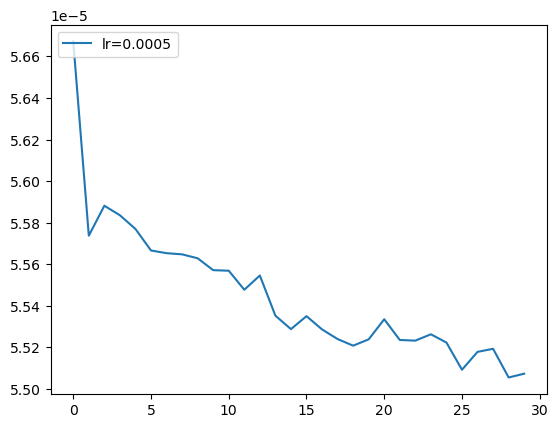

In [42]:
save_NN(model_nn_s,X_scaler_s,y_scaler,history_s,'Small')



In [43]:
eval_df_nn_s.head()

,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
420350,2.0,-0.066665,-0.040959,0.107624,1.933335,1.959041,1.329633,38.560313,47.770550,1.320852
56121,1.0,0.300001,-0.010544,0.289456,1.300001,0.989456,23.888082,103.514812,200.000000,27.128296
1006891,3.0,-0.450001,-0.073262,0.523262,2.549999,2.926738,14.774084,83.719656,143.996231,13.757790
702620,1.0,-0.733334,-0.198683,0.932017,0.266666,0.801317,200.494853,72.906912,114.729940,100.123560
257760,2.0,0.133333,-0.120323,0.013010,2.133333,1.879677,11.890099,190.242448,200.000000,12.641651


In [44]:
print('hello')

hello


In [45]:
eval_df_nn_s[['AE',"MAPE (KESES)","MAPE (MENETIDO)","SMAPE (KESES)","SMAPE (MENETIDO)"]].describe()

,AE,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
count,235047.000000,2.350470e+05,2.350470e+05,235047.000000,235047.000000
mean,0.557866,6.287729e+04,4.001550e+05,153.977641,26.695502
std,0.667830,6.883593e+06,5.819969e+06,55.515701,25.674145
min,0.000002,5.725321e-04,9.910747e-03,0.009910,0.000573
25%,0.169970,7.549202e+00,7.848422e+01,122.188190,7.666743
50%,0.377754,1.929348e+01,9.606836e+01,176.303250,19.490300
75%,0.687378,4.146716e+01,1.320944e+02,200.000000,37.716770
max,30.612380,1.047535e+09,1.369578e+09,200.000000,200.000000


In [46]:
del model_nn_s

In [ ]:
del raw_data_small
del raw_data
    

# loading the models and validate them

In [59]:
import pandas as pd
from config import generated_files_path

In [60]:
validation_data=pd.read_csv(generated_files_path+'validation_data.csv')


In [61]:
validation_data.tail()

,ESEMENY,ESEMENY_SORSZAM,TERV_IDOTARTAM (m),KESES (m),ELOZO_SZAKASZ_TERV_IDOTARTAM (m),ELOZO_SZAKASZ_KESES (m),ELOZO_SZAKASZ_RELATIV_KESES,CSATL_MAX_KESES (m),PUFFER,MENETREND_IDO (m),...,I,E,ÁI,ÁE,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
366655,2,15,0.0,0.200000,5.0,0.533333,0.050633,0.0,-0.533333,489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.383333,1.000000,0.0
366656,1,16,5.0,-0.683333,0.0,0.200000,1.000000,0.0,4.800000,494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.700000,-0.075269,0.0
366657,2,17,0.0,0.216667,5.0,-0.683333,-0.073345,0.0,0.683333,494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,1.000000,0.0
366658,1,18,11.0,0.200000,0.0,0.216667,1.000000,0.0,10.783333,505,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.116667,0.005275,0.0
366659,5,19,0.0,-0.516667,11.0,0.200000,0.009009,0.0,-0.200000,505,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.316667,1.000000,0.0


In [62]:
y=validation_data['KESES (m)']
X=validation_data
if 'KESES (m)' in X.columns:
    X=X.drop(columns=['KESES (m)'])
if 'RELATIV_KESES' in X.columns:
    X=X.drop(columns=['RELATIV_KESES'])
#X_additional=X[['VONATSZAM','KOZLEKEDESI_NAP']]
#X.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)
if 'KESES (m)' in attrs_to_use:
    attrs_to_use.remove('KESES (m)')
X_small=X[attrs_to_use]





In [63]:
#model/data_desc/model_desc
base_RT = load_sk_by_desc('RT','base','Base')['model']
small_RT = load_sk_by_desc('RT','base','Small')['model']


In [64]:
base_RT.feature_names_in_

array(['ESEMENY', 'ESEMENY_SORSZAM', 'TERV_IDOTARTAM (m)',
       'ELOZO_SZAKASZ_TERV_IDOTARTAM (m)', 'ELOZO_SZAKASZ_KESES (m)',
       'ELOZO_SZAKASZ_RELATIV_KESES', 'CSATL_MAX_KESES (m)', 'PUFFER',
       'MENETREND_IDO (m)', 'tx', 't', 'tn', 'r', 'LINE',
       'Érintett objektum típusa', 'Lassúmenet típusa',
       'Lassúmenet hossza', 'Lassúmenet mértéke (km/h)',
       'Lassúmenet mértéke motorvonatra (km/h)', 'Fels.vez. kikapcsolása',
       'I', 'E', 'ÁI', 'ÁE', 'Kizárás (1=VZ,2=LJ)',
       'Kiutalt menetvonalak zavartatása nélkül', 'Státus',
       'ELOZO_VONAT_KESES (m)', 'ELOZO_VONAT_RELATIV_KESES',
       'VONAL_STATUSZ_VALTOZOTT'], dtype=object)

In [65]:
small_RT.feature_names_in_


array(['MENETREND_IDO (m)', 'ELOZO_SZAKASZ_KESES (m)', 'tx', 't', 'tn',
       'r', 'TERV_IDOTARTAM (m)'], dtype=object)

In [66]:
y_pred_dt_base=small_RT.predict(X_small)
#small_RT_res=evaluate_model(X_small,y,y_pred)



In [67]:
y_pred_dt_small=base_RT.predict(X)
#base_RT_res=evaluate_model(X,y,y_pred)

In [68]:
del small_RT
del base_RT

In [69]:
validation_data.head()

,ESEMENY,ESEMENY_SORSZAM,TERV_IDOTARTAM (m),KESES (m),ELOZO_SZAKASZ_TERV_IDOTARTAM (m),ELOZO_SZAKASZ_KESES (m),ELOZO_SZAKASZ_RELATIV_KESES,CSATL_MAX_KESES (m),PUFFER,MENETREND_IDO (m),...,I,E,ÁI,ÁE,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
0,2,1,0.0,0.400000,0.0,0.000000,0.000000,0.00,0.000000,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,2,4.0,0.766667,0.0,0.400000,1.000000,0.00,3.600000,29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,3,1.0,-0.500000,4.0,0.766667,0.087452,0.00,0.233333,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,4,5.0,-0.750000,1.0,-0.500000,-0.333333,0.00,5.500000,35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2,5,1.0,0.233333,5.0,-0.750000,-0.081081,1.75,1.750000,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [70]:
import torch
base_X_scaler=load_sk_by_desc('X_scaler','base','base')['model']
base_y_scaler=load_sk_by_desc('y_scaler','base','base')['model']

X_t = torch.tensor(base_X_scaler.transform(X), dtype=torch.float32)
nn_base=load_NN('./model/NN/base/base/')['model']
y_pred_nn_base=base_y_scaler.inverse_transform(nn_base(X_t).detach().numpy())
del base_X_scaler
del base_y_scaler
del nn_base
del X_t


Unspecified file: history.png
Unspecified file: history_.png
Loading model: ./model/NN/base/base/NN_base_base.pth


In [71]:
attrs_to_use

['MENETREND_IDO (m)',
 'ELOZO_SZAKASZ_KESES (m)',
 'tx',
 't',
 'tn',
 'r',
 'TERV_IDOTARTAM (m)']

In [72]:


small_X_scaler=load_sk_by_desc('X_scaler','base','Small')['model']
small_y_scaler=load_sk_by_desc('y_scaler','base','Small')['model']

X_t = torch.tensor(small_X_scaler.transform(X_small), dtype=torch.float32)
nn_small=load_NN('./model/NN/Small/base/')['model']
y_pred_nn_small=small_y_scaler.inverse_transform(nn_small(X_t).detach().numpy())
del small_X_scaler
del small_y_scaler
del nn_small
del X_t



Unspecified file: history.png
Loading model: ./model/NN/Small/base/NN_Small_base.pth


In [73]:
#del y
del X
del X_small

In [74]:
names = ['P-NN-small','P-NN','P-DT','P-DT-small','KESES']
#preds=[y_pred_nn_base.squeeze(),y_pred_nn_small.squeeze(),y_pred_dt_base,y_pred_dt_small,y]
preds=[y_pred_nn_small.squeeze(),y_pred_nn_base.squeeze() ,y_pred_dt_base,y_pred_dt_small,y]
cols_to_add=pd.DataFrame(dict(zip(names,preds)))

In [75]:
type(y_pred_dt_small[:5])

numpy.ndarray

In [76]:
#y_pred_dt_small.reshape(1,).shape

In [77]:
type(y_pred_nn_base[:5])

numpy.ndarray

In [78]:
y_pred_nn_base.squeeze().shape

(366660,)

In [79]:
df_to_validate_orig=pd.read_pickle(generated_files_path+'validation_orig.pkl')
df_to_validate_orig.drop(columns=['KESES (m)'], inplace=True)

In [80]:
df_to_validate_orig.reset_index(drop=True, inplace=True)
cols_to_add.reset_index(drop=True, inplace=True)

In [81]:
eval_df=pd.concat([df_to_validate_orig,cols_to_add], axis=1)

In [82]:
eval_df.head()

,VONATSZAM,KOZLEKEDESI_NAP,ESEMENY,ESEMENY_SORSZAM,IDO,TENY_IDO,OSSZ_KESES (m),TERV_IDOTARTAM (m),TENY_IDOTARTAM (m),RELATIV_KESES,...,Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT,P-NN-small,P-NN,P-DT,P-DT-small,KESES
0,2010,2022-01-01,2,1,2022-01-01 00:25:00,2022-01-01 00:25:24,0.400000,0.0,0.400000,1.000000,...,0.0,0.0,0.0,0.0,True,0.384452,0.771146,0.389359,0.273222,0.400000
1,2010,2022-01-01,1,2,2022-01-01 00:29:00,2022-01-01 00:30:10,1.166667,4.0,4.766667,0.087452,...,0.0,0.0,0.0,0.0,True,-0.052405,-0.159070,0.885247,0.016136,0.766667
2,2010,2022-01-01,2,3,2022-01-01 00:30:00,2022-01-01 00:30:40,0.666667,1.0,0.500000,-0.333333,...,0.0,0.0,0.0,0.0,True,-0.371149,-0.445388,-0.375597,0.016136,-0.500000
3,2010,2022-01-01,1,4,2022-01-01 00:35:00,2022-01-01 00:34:55,-0.083333,5.0,4.250000,-0.081081,...,0.0,0.0,0.0,0.0,True,-0.095594,-0.284052,-0.655002,-0.132221,-0.750000
4,2010,2022-01-01,2,5,2022-01-01 00:36:00,2022-01-01 00:36:09,0.150000,1.0,1.233333,0.104478,...,0.0,0.0,0.0,0.0,True,-0.140928,-0.361812,0.044636,0.016136,0.233333


In [83]:
eval_df.to_pickle(generated_files_path+'validation_res.pkl')

In [141]:
preds_=pd.read_pickle(generated_files_path+'validation_res.pkl')


In [142]:
preds_

,VONATSZAM,KOZLEKEDESI_NAP,ESEMENY,ESEMENY_SORSZAM,IDO,TENY_IDO,OSSZ_KESES (m),TERV_IDOTARTAM (m),TENY_IDOTARTAM (m),RELATIV_KESES,...,Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT,P-NN-small,P-NN,P-DT,P-DT-small,KESES
0,2010,2022-01-01,2,1,2022-01-01 00:25:00,2022-01-01 00:25:24,0.400000,0.0,0.400000,1.000000,...,0.0,0.0,0.000000,0.000000,True,0.384452,0.771146,0.389359,0.273222,0.400000
1,2010,2022-01-01,1,2,2022-01-01 00:29:00,2022-01-01 00:30:10,1.166667,4.0,4.766667,0.087452,...,0.0,0.0,0.000000,0.000000,True,-0.052405,-0.159070,0.885247,0.016136,0.766667
2,2010,2022-01-01,2,3,2022-01-01 00:30:00,2022-01-01 00:30:40,0.666667,1.0,0.500000,-0.333333,...,0.0,0.0,0.000000,0.000000,True,-0.371149,-0.445388,-0.375597,0.016136,-0.500000
3,2010,2022-01-01,1,4,2022-01-01 00:35:00,2022-01-01 00:34:55,-0.083333,5.0,4.250000,-0.081081,...,0.0,0.0,0.000000,0.000000,True,-0.095594,-0.284052,-0.655002,-0.132221,-0.750000
4,2010,2022-01-01,2,5,2022-01-01 00:36:00,2022-01-01 00:36:09,0.150000,1.0,1.233333,0.104478,...,0.0,0.0,0.000000,0.000000,True,-0.140928,-0.361812,0.044636,0.016136,0.233333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366655,37467,2023-12-24,2,15,2023-12-24 08:09:00,2023-12-24 08:09:47,0.783333,0.0,0.200000,1.000000,...,0.0,0.0,0.383333,1.000000,False,0.167699,0.044952,0.143133,0.556548,0.200000
366656,37467,2023-12-24,1,16,2023-12-24 08:14:00,2023-12-24 08:14:06,0.100000,5.0,4.316667,-0.073345,...,0.0,0.0,-0.700000,-0.075269,False,-0.312862,-0.367041,-0.046282,-0.554830,-0.683333
366657,37467,2023-12-24,2,17,2023-12-24 08:14:00,2023-12-24 08:14:19,0.316667,0.0,0.216667,1.000000,...,0.0,0.0,0.333333,1.000000,False,0.313544,0.361744,0.357081,0.376914,0.216667
366658,37467,2023-12-24,1,18,2023-12-24 08:25:00,2023-12-24 08:25:31,0.516667,11.0,11.200000,0.009009,...,0.0,0.0,0.116667,0.005275,False,-0.012575,-0.009854,0.146182,0.112550,0.200000


In [143]:
preds_.columns

Index(['VONATSZAM', 'KOZLEKEDESI_NAP', 'ESEMENY', 'ESEMENY_SORSZAM', 'IDO',
       'TENY_IDO', 'OSSZ_KESES (m)', 'TERV_IDOTARTAM (m)',
       'TENY_IDOTARTAM (m)', 'RELATIV_KESES',
       'ELOZO_SZAKASZ_TERV_IDOTARTAM (m)', 'ELOZO_SZAKASZ_KESES (m)',
       'ELOZO_SZAKASZ_RELATIV_KESES', 'ID', 'CSATL_MAX_KESES (m)', 'PUFFER',
       'MENETREND_IDO (m)', 'tx', 't', 'tn', 'r', 'LINE',
       'Érintett objektum típusa', 'Lassúmenet típusa', 'Lassúmenet hossza',
       'Lassúmenet mértéke (km/h)', 'Lassúmenet mértéke motorvonatra (km/h)',
       'Fels.vez. kikapcsolása', 'I', 'E', 'ÁI', 'ÁE', 'Kezdés', 'Befejezés',
       'Kizárás (1=VZ,2=LJ)', 'Kiutalt menetvonalak zavartatása nélkül',
       'Státus', 'ELOZO_VONAT_KESES (m)', 'ELOZO_VONAT_RELATIV_KESES',
       'VONAL_STATUSZ_VALTOZOTT', 'P-NN-small', 'P-NN', 'P-DT', 'P-DT-small',
       'KESES'],
      dtype='object')

In [177]:
eval_df=preds_.copy()

In [178]:
eval_df.head()

,VONATSZAM,KOZLEKEDESI_NAP,ESEMENY,ESEMENY_SORSZAM,IDO,TENY_IDO,OSSZ_KESES (m),TERV_IDOTARTAM (m),TENY_IDOTARTAM (m),RELATIV_KESES,...,Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT,P-NN-small,P-NN,P-DT,P-DT-small,KESES
0,2010,2022-01-01,2,1,2022-01-01 00:25:00,2022-01-01 00:25:24,0.400000,0.0,0.400000,1.000000,...,0.0,0.0,0.0,0.0,True,0.384452,0.771146,0.389359,0.273222,0.400000
1,2010,2022-01-01,1,2,2022-01-01 00:29:00,2022-01-01 00:30:10,1.166667,4.0,4.766667,0.087452,...,0.0,0.0,0.0,0.0,True,-0.052405,-0.159070,0.885247,0.016136,0.766667
2,2010,2022-01-01,2,3,2022-01-01 00:30:00,2022-01-01 00:30:40,0.666667,1.0,0.500000,-0.333333,...,0.0,0.0,0.0,0.0,True,-0.371149,-0.445388,-0.375597,0.016136,-0.500000
3,2010,2022-01-01,1,4,2022-01-01 00:35:00,2022-01-01 00:34:55,-0.083333,5.0,4.250000,-0.081081,...,0.0,0.0,0.0,0.0,True,-0.095594,-0.284052,-0.655002,-0.132221,-0.750000
4,2010,2022-01-01,2,5,2022-01-01 00:36:00,2022-01-01 00:36:09,0.150000,1.0,1.233333,0.104478,...,0.0,0.0,0.0,0.0,True,-0.140928,-0.361812,0.044636,0.016136,0.233333


In [191]:
eval_df['TENY_IDOTARTAM']=eval_df['TERV_IDOTARTAM (m)']+eval_df['KESES']
if 'KESES' in names:
    names.remove('KESES')
#eval_df=eval_df[['VONATSZAM','KOZLEKEDESI_NAP','KESES','OSSZ_KESES (m)','TENY_IDOTARTAM (m)','TERV_IDOTARTAM (m)']+names]
metrics=[]
aes=[]
ape_stat_s=[]
apes_delay_s=[]
s_ape_stats_menetido=[]
s_ape_stats_keses=[]
zero_cls=[]
eval_df['0']=0.0
names+=['0']
for n in names:
    print(n)
    #eval_df.loc[eval_df['PUFFER']>1,n]=0
    eval_df['JOSOLT_IDOTARTAM ' + n]=eval_df['TERV_IDOTARTAM (m)']+eval_df[n]
    
    # menetido alapján
    eval_df[f'{n} AE (MENETIDO)']=abs(eval_df['TENY_IDOTARTAM (m)']-eval_df['JOSOLT_IDOTARTAM ' + n])
    metrics.append(f'{n} AE (MENETIDO)')
    aes.append(f'{n} AE (MENETIDO)')

    eval_df[f'{n} S-APE (KESES)']=abs(eval_df[n]-eval_df['KESES'])/((abs(eval_df['KESES'])+abs(eval_df[n]))) *100
    eval_df[f'{n} S-APE (MENETIDO)']=abs(eval_df['JOSOLT_IDOTARTAM ' + n]-eval_df['TENY_IDOTARTAM (m)'])/((abs(eval_df['TENY_IDOTARTAM (m)'])+abs(eval_df['JOSOLT_IDOTARTAM ' + n]))) *100
    #aes.append(f'{n} S-APE (KESES)')
    #aes.append(f'{n} S-APE (MENETIDO)')
    s_ape_stats_keses.append(f'{n} S-APE (KESES)')
    s_ape_stats_menetido.append(f'{n} S-APE (MENETIDO)')
    metrics.append(f'{n} S-APE (KESES)')
    metrics.append(f'{n} S-APE (MENETIDO)')


    eval_df[f'{n} APE (MENETIDO)']=abs(eval_df['TENY_IDOTARTAM (m)']-eval_df['JOSOLT_IDOTARTAM ' + n])/eval_df['TENY_IDOTARTAM (m)'] *100
    #metrics.append(f'{n} APE (MENETIDO)')
    ape_stat_s.append(f'{n} APE (MENETIDO)')

    eval_df[f'{n} APE (KESES)']=abs(eval_df['KESES']-eval_df[n])/eval_df['KESES'] *100
    #metrics.append(f'{n} APE (KESES)')
    apes_delay_s.append(f'{n} APE (KESES)')



P-NN-small
P-NN
P-DT
P-DT-small
0


In [196]:
print(eval_df[['0 AE (MENETIDO)','0 S-APE (MENETIDO)','0 S-APE (KESES)']].describe().to_latex())

\begin{tabular}{lrrr}
\toprule
 & 0 AE (MENETIDO) & 0 S-APE (MENETIDO) & 0 S-APE (KESES) \\
\midrule
count & 366660.000000 & 315951.000000 & 306823.000000 \\
mean & 0.493899 & 32.368137 & 100.000000 \\
std & 0.746313 & 37.480117 & 0.000000 \\
min & 0.000000 & 0.000000 & 100.000000 \\
25% & 0.083333 & 4.895105 & 100.000000 \\
50% & 0.366667 & 15.384615 & 100.000000 \\
75% & 0.600000 & 41.176471 & 100.000000 \\
max & 62.833333 & 100.000000 & 100.000000 \\
\bottomrule
\end{tabular}



In [164]:
eval_df

,VONATSZAM,KOZLEKEDESI_NAP,ESEMENY,ESEMENY_SORSZAM,IDO,TENY_IDO,OSSZ_KESES (m),TERV_IDOTARTAM (m),TENY_IDOTARTAM (m),RELATIV_KESES,...,P-DT S-APE (KESES),P-DT S-APE (MENETIDO),P-DT APE (MENETIDO),P-DT APE (KESES),JOSOLT_IDOTARTAM P-DT-small,P-DT-small AE (MENETIDO),P-DT-small S-APE (KESES),P-DT-small S-APE (MENETIDO),P-DT-small APE (MENETIDO),P-DT-small APE (KESES)
0,2010,2022-01-01,2,1,2022-01-01 00:25:00,2022-01-01 00:25:24,0.400000,0.0,0.400000,1.000000,...,2.696165,2.696165,2.660302,2.660302,0.273222,0.126778,37.663053,37.663053,31.694496,31.694496
1,2010,2022-01-01,1,2,2022-01-01 00:29:00,2022-01-01 00:30:10,1.166667,4.0,4.766667,0.087452,...,200.000000,17.490494,16.083916,100.000000,4.000000,0.766667,200.000000,17.490494,16.083916,100.000000
2,2010,2022-01-01,2,3,2022-01-01 00:30:00,2022-01-01 00:30:40,0.666667,1.0,0.500000,-0.333333,...,28.415632,22.127860,24.880637,-24.880637,1.016136,0.516136,200.000000,68.085701,103.227173,-103.227173
3,2010,2022-01-01,1,4,2022-01-01 00:35:00,2022-01-01 00:34:55,-0.083333,5.0,4.250000,-0.081081,...,200.000000,16.216216,17.647059,-100.000000,5.000000,0.750000,200.000000,16.216216,17.647059,-100.000000
4,2010,2022-01-01,2,5,2022-01-01 00:36:00,2022-01-01 00:36:09,0.150000,1.0,1.233333,0.104478,...,200.000000,20.895522,18.918919,100.000000,1.000000,0.233333,200.000000,20.895522,18.918919,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366655,37467,2023-12-24,2,15,2023-12-24 08:09:00,2023-12-24 08:09:47,0.783333,0.0,0.200000,1.000000,...,33.145579,33.145579,28.433375,28.433375,0.556548,0.356548,94.256483,94.256483,178.273781,178.273781
366656,37467,2023-12-24,1,16,2023-12-24 08:14:00,2023-12-24 08:14:06,0.100000,5.0,4.316667,-0.073345,...,200.000000,14.669052,15.830116,-100.000000,5.000000,0.683333,200.000000,14.669052,15.830116,-100.000000
366657,37467,2023-12-24,2,17,2023-12-24 08:14:00,2023-12-24 08:14:19,0.316667,0.0,0.216667,1.000000,...,48.946342,48.946342,64.806563,64.806563,0.376914,0.160248,53.993550,53.993550,73.960499,73.960499
366658,37467,2023-12-24,1,18,2023-12-24 08:25:00,2023-12-24 08:25:31,0.516667,11.0,11.200000,0.009009,...,200.000000,1.801802,1.785714,100.000000,11.000000,0.200000,200.000000,1.801802,1.785714,100.000000


In [165]:
ae_eval=eval_df.sort_values('P-DT-small AE (MENETIDO)')

In [166]:
explanation_fields=['VONATSZAM','KOZLEKEDESI_NAP','ID','ESEMENY','ESEMENY_SORSZAM','IDO','TENY_IDO','TERV_IDOTARTAM (m)','TENY_IDOTARTAM (m)','CSATL_MAX_KESES (m)','KESES','P-DT-small AE (MENETIDO)','P-DT-small']

to_check_fields=['PUFFER','ELOZO_SZAKASZ_KESES (m)','CSATL_MAX_KESES (m)']
ae_eval[explanation_fields+to_check_fields].tail(20)

,VONATSZAM,KOZLEKEDESI_NAP,ID,ESEMENY,ESEMENY_SORSZAM,IDO,TENY_IDO,TERV_IDOTARTAM (m),TENY_IDOTARTAM (m),CSATL_MAX_KESES (m),KESES,P-DT-small AE (MENETIDO),P-DT-small,PUFFER,ELOZO_SZAKASZ_KESES (m),CSATL_MAX_KESES (m)
348175,2127,2023-11-28,10082-10082,2,27,2023-11-28 07:44:00,2023-11-28 08:03:00,0.0,19.000000,49.000000,19.000000,19.000000,0.000000,12.783333,-12.783333,49.000000
206248,2127,2023-11-28,10082-10082,2,27,2023-11-28 07:44:00,2023-11-28 08:03:00,0.0,19.000000,49.000000,19.000000,19.000000,0.000000,12.783333,-12.783333,49.000000
366353,37431,2023-12-19,17137-17137,5,19,2023-12-19 21:27:00,2023-12-19 21:27:00,0.0,-20.900000,0.000000,-20.900000,19.190196,-1.709804,-0.950000,0.950000,0.000000
365631,37418,2023-11-03,17434-17434,2,15,2023-11-03 20:11:00,2023-11-03 20:57:50,1.0,21.183333,0.000000,20.183333,20.183333,0.000000,1.100000,-0.100000,0.000000
232090,37418,2023-11-03,17434-17434,2,15,2023-11-03 20:11:00,2023-11-03 20:57:50,1.0,21.183333,0.000000,20.183333,20.183333,0.000000,1.100000,-0.100000,0.000000
361877,37428,2023-06-20,18184-18184,5,21,2023-06-20 22:27:00,2023-06-20 22:27:00,0.0,-23.183333,0.000000,-23.183333,20.857692,-2.325641,-0.650000,0.650000,0.000000
228612,37428,2023-06-20,17137-17137,2,1,2023-06-20 21:34:00,2023-06-20 21:55:51,0.0,21.850000,18.550000,21.850000,21.174238,0.675762,0.000000,0.000000,18.550000
364427,37412,2023-10-11,18184-18184,5,19,2023-10-11 10:26:00,2023-10-11 10:26:00,0.0,-23.350000,0.000000,-23.350000,21.700568,-1.649432,-0.600000,0.600000,0.000000
349056,3255,2023-11-28,10272-40121,3,24,2023-11-28 14:56:00,2023-11-28 14:34:01,3.0,-18.983333,0.000000,-21.983333,21.983333,0.000000,3.000000,0.000000,0.000000
207075,3255,2023-11-28,10272-40121,3,24,2023-11-28 14:56:00,2023-11-28 14:34:01,3.0,-18.983333,0.000000,-21.983333,21.983333,0.000000,3.000000,0.000000,0.000000


In [192]:
ae_res=eval_df[aes].describe()

In [193]:
ae_res

,P-NN-small AE (MENETIDO),P-NN AE (MENETIDO),P-DT AE (MENETIDO),P-DT-small AE (MENETIDO),0 AE (MENETIDO)
count,3.666600e+05,3.666600e+05,366660.000000,366660.000000,366660.000000
mean,4.753491e-01,3.083881e-01,0.438968,0.275322,0.493899
std,7.118049e-01,6.295625e-01,0.680714,0.595975,0.746313
min,8.488695e-07,8.488695e-07,0.000000,0.000000,0.000000
25%,1.833938e-01,6.029908e-02,0.150080,0.033864,0.083333
50%,3.054281e-01,1.600588e-01,0.296208,0.119117,0.366667
75%,5.255623e-01,3.306207e-01,0.501995,0.293462,0.600000
max,6.259681e+01,5.871170e+01,62.443975,49.821875,62.833333


In [194]:
print(ae_res.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & P-NN-small AE (MENETIDO) & P-NN AE (MENETIDO) & P-DT AE (MENETIDO) & P-DT-small AE (MENETIDO) & 0 AE (MENETIDO) \\
\midrule
count & 366660.000000 & 366660.000000 & 366660.000000 & 366660.000000 & 366660.000000 \\
mean & 0.475349 & 0.308388 & 0.438968 & 0.275322 & 0.493899 \\
std & 0.711805 & 0.629563 & 0.680714 & 0.595975 & 0.746313 \\
min & 0.000001 & 0.000001 & 0.000000 & 0.000000 & 0.000000 \\
25% & 0.183394 & 0.060299 & 0.150080 & 0.033864 & 0.083333 \\
50% & 0.305428 & 0.160059 & 0.296208 & 0.119117 & 0.366667 \\
75% & 0.525562 & 0.330621 & 0.501995 & 0.293462 & 0.600000 \\
max & 62.596809 & 58.711697 & 62.443975 & 49.821875 & 62.833333 \\
\bottomrule
\end{tabular}



In [182]:
eval_df[s_ape_stats_menetido].describe()

,P-NN-small S-APE (MENETIDO),P-NN S-APE (MENETIDO),P-DT S-APE (MENETIDO),P-DT-small S-APE (MENETIDO)
count,366660.000000,366660.000000,366586.000000,361752.000000
mean,30.270759,24.146097,28.529142,22.060598
std,32.923159,33.526525,33.440951,32.863350
min,0.000019,0.000049,0.000000,0.000000
25%,6.067260,3.032382,5.120800,2.309836
50%,17.187591,8.453878,13.791240,6.873454
75%,39.863746,25.153174,35.663925,21.689648
max,100.000000,100.000000,100.000000,100.000000


In [185]:
print(eval_df[s_ape_stats_menetido].describe().to_latex())

\begin{tabular}{lrrrr}
\toprule
 & P-NN-small S-APE (MENETIDO) & P-NN S-APE (MENETIDO) & P-DT S-APE (MENETIDO) & P-DT-small S-APE (MENETIDO) \\
\midrule
count & 366660.000000 & 366660.000000 & 366586.000000 & 361752.000000 \\
mean & 30.270759 & 24.146097 & 28.529142 & 22.060598 \\
std & 32.923159 & 33.526525 & 33.440951 & 32.863350 \\
min & 0.000019 & 0.000049 & 0.000000 & 0.000000 \\
25% & 6.067260 & 3.032382 & 5.120800 & 2.309836 \\
50% & 17.187591 & 8.453878 & 13.791240 & 6.873454 \\
75% & 39.863746 & 25.153174 & 35.663925 & 21.689648 \\
max & 100.000000 & 100.000000 & 100.000000 & 100.000000 \\
\bottomrule
\end{tabular}



In [186]:
print(eval_df[s_ape_stats_keses].describe().to_latex())


\begin{tabular}{lrrrr}
\toprule
 & P-NN-small S-APE (KESES) & P-NN S-APE (KESES) & P-DT S-APE (KESES) & P-DT-small S-APE (KESES) \\
\midrule
count & 366660.000000 & 366660.000000 & 366576.000000 & 361732.000000 \\
mean & 73.219143 & 50.515588 & 64.752487 & 48.457084 \\
std & 30.438007 & 38.398256 & 35.214773 & 39.813107 \\
min & 0.000173 & 0.000161 & 0.000000 & 0.000000 \\
25% & 47.612051 & 14.295957 & 32.056882 & 10.282857 \\
50% & 85.719084 & 40.074875 & 69.465759 & 35.141862 \\
75% & 100.000000 & 100.000000 & 100.000000 & 100.000000 \\
max & 100.000000 & 100.000000 & 100.000000 & 100.000000 \\
\bottomrule
\end{tabular}



In [149]:
# nem megállás (tényidő=0), megállás ahol ugyanaz az induló és érkező idő(tervidő=0), végállomás (tervidő=0), negatív tény
eval_df_restrcited=eval_df[(eval_df['TERV_IDOTARTAM (m)']>0) & (eval_df['TENY_IDOTARTAM (m)']>0)]

In [96]:
eval_df_restrcited.head()

,VONATSZAM,KOZLEKEDESI_NAP,KESES,OSSZ_KESES (m),TENY_IDOTARTAM (m),TERV_IDOTARTAM (m),P-NN-small,P-NN,P-DT,P-DT-small,...,P-DT S-APE (KESES),P-DT S-APE (MENETIDO),P-DT APE (MENETIDO),P-DT APE (KESES),JOSOLT_IDOTARTAM P-DT-small,P-DT-small AE (MENETIDO),P-DT-small S-APE (KESES),P-DT-small S-APE (MENETIDO),P-DT-small APE (MENETIDO),P-DT-small APE (KESES)
1,2010,2022-01-01,0.766667,1.166667,4.766667,4.0,-0.052405,-0.159070,0.885247,0.016136,...,14.356678,2.457128,2.487691,15.466948,4.016136,0.750531,191.754823,17.090918,15.745401,97.895322
2,2010,2022-01-01,-0.500000,0.666667,0.500000,1.0,-0.371149,-0.445388,-0.375597,0.016136,...,28.415632,22.127860,24.880637,-24.880637,1.016136,0.516136,200.000000,68.085701,103.227173,-103.227173
3,2010,2022-01-01,-0.750000,-0.083333,4.250000,5.0,-0.095594,-0.284052,-0.655002,-0.132221,...,13.522877,2.210549,2.235255,-12.666443,4.867779,0.617779,140.050973,13.551092,14.535984,-82.370576
4,2010,2022-01-01,0.233333,0.150000,1.233333,1.0,-0.140928,-0.361812,0.044636,0.016136,...,135.768535,16.567159,15.299789,80.870315,1.016136,0.217197,174.127687,19.310998,17.610606,93.084630
5,2010,2022-01-01,-0.416667,-0.266667,1.583333,2.0,-0.170791,-0.379280,-0.482218,0.016136,...,14.585006,4.227587,4.140075,-15.732283,2.016136,0.432803,200.000000,24.048131,27.334897,-103.872607


In [150]:
ape_stat_res=eval_df_restrcited[aes].describe()

In [154]:
ae_sorted_restricted=eval_df_restrcited.sort_values('P-DT-small AE (MENETIDO)')

In [162]:
ae_sorted_restricted[explanation_fields+to_check_fields].head(10)

,VONATSZAM,KOZLEKEDESI_NAP,ID,ESEMENY,ESEMENY_SORSZAM,IDO,TENY_IDO,TERV_IDOTARTAM (m),TENY_IDOTARTAM (m),CSATL_MAX_KESES (m),KESES,P-DT-small AE (MENETIDO),P-DT-small,PUFFER,ELOZO_SZAKASZ_KESES (m),CSATL_MAX_KESES (m)
43383,3252,2022-06-03,1438-1438,2,26,2022-06-03 12:40:00,2022-06-03 12:40:07,3.0,1.4,-1.133333,-1.6,0.0,-1.6,3.666667,-0.666667,-1.133333
231282,32614,2023-10-19,18184-18184,2,19,2023-10-19 14:32:00,2023-10-19 14:39:56,6.0,2.2,117.516667,-3.8,0.0,-3.8,5.083333,0.916667,117.516667
260931,2031,2023-03-24,1487-1487,2,8,2023-03-24 19:19:00,2023-03-24 19:19:00,1.0,1.0,-1.000000,0.0,0.0,0.0,5.000000,-4.000000,-1.000000
262581,3217,2023-03-24,10207-10207,2,17,2023-03-24 08:43:00,2023-03-24 08:43:00,1.0,1.0,0.000000,0.0,0.0,0.0,6.000000,-5.000000,0.000000
261259,2043,2023-03-24,1487-1487,2,8,2023-03-24 15:49:00,2023-03-24 15:49:00,1.0,1.0,-9.000000,0.0,0.0,0.0,5.000000,-4.000000,-9.000000
261421,2050,2023-03-24,10207-10207,2,5,2023-03-24 05:32:00,2023-03-24 05:32:00,1.0,1.0,-5.000000,0.0,0.0,0.0,5.000000,-4.000000,-5.000000
261427,2050,2023-03-24,1420-1420,2,10,2023-03-24 05:42:00,2023-03-24 05:42:00,1.0,1.0,-11.000000,0.0,0.0,0.0,7.000000,-6.000000,-11.000000
123989,2043,2023-03-24,1487-1487,2,8,2023-03-24 15:49:00,2023-03-24 15:49:00,1.0,1.0,-9.000000,0.0,0.0,0.0,5.000000,-4.000000,-9.000000
261489,2051,2023-03-24,10207-10207,2,29,2023-03-24 20:58:00,2023-03-24 20:58:00,1.0,1.0,3.000000,0.0,0.0,0.0,6.000000,-5.000000,3.000000
123682,2031,2023-03-24,1487-1487,2,8,2023-03-24 19:19:00,2023-03-24 19:19:00,1.0,1.0,-1.000000,0.0,0.0,0.0,5.000000,-4.000000,-1.000000


In [152]:
eval_df_restrcited[s_ape_stats_keses].describe()

,P-NN-small S-APE (KESES),P-NN S-APE (KESES),P-DT S-APE (KESES),P-DT-small S-APE (KESES)
count,247092.000000,247092.000000,247082.000000,247072.000000
mean,153.803485,97.117183,132.258735,94.781204
std,55.745633,72.452985,67.268456,75.621598
min,0.016142,0.000323,0.000000,0.000000
25%,121.581592,30.772133,74.194133,23.866966
50%,176.414776,79.905074,141.442704,73.020262
75%,200.000000,182.828650,200.000000,197.623703
max,200.000000,200.000000,200.000000,200.000000


In [159]:
sape_m_sorted_restricted=eval_df_restrcited.sort_values('P-DT-small S-APE (MENETIDO)')


In [161]:
sape_m_sorted_restricted[explanation_fields].tail(10)

,VONATSZAM,KOZLEKEDESI_NAP,ID,ESEMENY,ESEMENY_SORSZAM,IDO,TENY_IDO,TERV_IDOTARTAM (m),TENY_IDOTARTAM (m),CSATL_MAX_KESES (m),KESES,P-DT-small AE (MENETIDO),P-DT-small
262736,3227,2023-03-24,40113-10233,1,20,2023-03-24 09:21:00,2023-03-24 09:21:00,2.0,2.0,0.0,0.0,2.762654,-2.762654
263046,3251,2023-03-24,1438-1433,1,2,2023-03-24 22:24:00,2023-03-24 22:24:00,2.0,2.0,0.0,0.0,2.762654,-2.762654
125587,3243,2023-03-24,40113-10233,1,20,2023-03-24 18:21:00,2023-03-24 18:21:00,2.0,2.0,0.0,0.0,2.762654,-2.762654
262896,3239,2023-03-24,1438-1433,1,2,2023-03-24 06:24:00,2023-03-24 06:24:00,2.0,2.0,0.0,0.0,2.762654,-2.762654
125512,3239,2023-03-24,1438-1433,1,2,2023-03-24 06:24:00,2023-03-24 06:24:00,2.0,2.0,0.0,0.0,2.762654,-2.762654
262826,3233,2023-03-24,40113-10233,1,21,2023-03-24 17:51:00,2023-03-24 17:51:00,2.0,2.0,0.0,0.0,2.762654,-2.762654
125450,3233,2023-03-24,40113-10233,1,21,2023-03-24 17:51:00,2023-03-24 17:51:00,2.0,2.0,0.0,0.0,2.762654,-2.762654
125366,3227,2023-03-24,40113-10233,1,20,2023-03-24 09:21:00,2023-03-24 09:21:00,2.0,2.0,0.0,0.0,2.762654,-2.762654
262976,3243,2023-03-24,40113-10233,1,20,2023-03-24 18:21:00,2023-03-24 18:21:00,2.0,2.0,0.0,0.0,2.762654,-2.762654
125863,3261,2023-03-24,40113-10233,1,20,2023-03-24 23:21:00,2023-03-24 23:21:00,2.0,2.0,0.0,0.0,2.762654,-2.762654


In [153]:
eval_df_restrcited[s_ape_stats_menetido].describe()


,P-NN-small S-APE (MENETIDO),P-NN S-APE (MENETIDO),P-DT S-APE (MENETIDO),P-DT-small S-APE (MENETIDO)
count,247092.000000,247092.000000,247092.000000,247092.000000
mean,26.295714,18.661306,24.632613,17.317859
std,24.635528,22.557474,24.273949,22.221826
min,0.000038,0.000098,0.000000,0.000000
25%,7.568325,4.227616,7.325184,3.278350
50%,19.119912,10.189878,16.921374,8.594414
75%,37.494176,24.370462,34.133064,22.472972
max,198.266748,200.000000,200.000000,200.000000


In [100]:
apes_delay_res=eval_df_restrcited[apes_delay_s].describe()
print(apes_delay_res.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & P-NN-small APE (KESES) & P-NN APE (KESES) & P-DT APE (KESES) & P-DT-small APE (KESES) \\
\midrule
count & 247834.000000 & 247834.000000 & 247824.000000 & 247814.000000 \\
mean & inf & inf & inf & inf \\
std & NaN & NaN & NaN & NaN \\
min & -3449.545527 & -12244.983578 & -21889.285714 & -16475.924933 \\
25% & -86.674407 & -55.900732 & -80.872730 & -62.150350 \\
50% & -49.307955 & -10.446956 & -31.586775 & -8.528017 \\
75% & 120.480789 & 75.024034 & 111.843908 & 59.678050 \\
max & inf & inf & inf & inf \\
\bottomrule
\end{tabular}



In [ ]:
# H

In [130]:
raw_data=pd.read_pickle(generated_files_path+'data.pkl')


In [140]:
raw_data[(raw_data['VONATSZAM']==3255) & (raw_data['KOZLEKEDESI_NAP'].astype(str)=='2023-11-28')]

,VONATSZAM,KOZLEKEDESI_NAP,ESEMENY,ALLOMAS,ESEMENY_SORSZAM,IDO,TENY_IDO,SZH_KOD_x,OSSZ_KESES (m),TERV_IDOTARTAM (m),...,ÁI,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
2211614,3255,2023-11-28,2,1438,1,2023-11-28 14:22:00,2023-11-28 14:22:00,551438,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,1.000000,False
2211615,3255,2023-11-28,1,1433,2,2023-11-28 14:24:00,2023-11-28 14:24:00,551433,0.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.300000,-0.081081,False
2211616,3255,2023-11-28,2,1433,3,2023-11-28 14:24:00,2023-11-28 14:24:00,551433,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.516667,1.000000,False
2211617,3255,2023-11-28,1,1428,4,2023-11-28 14:26:00,2023-11-28 14:26:00,551428,0.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016667,0.004149,False
2211618,3255,2023-11-28,2,1428,5,2023-11-28 14:26:00,2023-11-28 14:26:00,551428,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.516667,1.000000,False
2211619,3255,2023-11-28,1,1420,6,2023-11-28 14:28:00,2023-11-28 14:28:00,551420,0.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.383333,-0.105991,False
2211620,3255,2023-11-28,2,1420,7,2023-11-28 14:29:00,2023-11-28 14:29:00,551420,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.416667,-0.263158,False
2211621,3255,2023-11-28,1,1412,8,2023-11-28 14:32:00,2023-11-28 14:32:00,551412,0.000000,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533333,0.081633,False
2211622,3255,2023-11-28,2,1412,9,2023-11-28 14:32:00,2023-11-28 14:32:00,551412,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.483333,1.000000,False
2211623,3255,2023-11-28,1,1408,10,2023-11-28 14:34:00,2023-11-28 14:34:00,551408,0.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.583333,-0.170732,False


In [135]:
pd.to_datetime('2023-11-28').date()

datetime.date(2023, 11, 28)

In [137]:
raw_data.head()['KOZLEKEDESI_NAP'].astype(str)

0    2022-01-01
1    2022-01-01
2    2022-01-01
3    2022-01-01
4    2022-01-01
Name: KOZLEKEDESI_NAP, dtype: object